In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, recall_score
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Lectura del Dataset
df = pd.read_csv("/content/drive/MyDrive/PFC1/Datasets/creditcard.csv")
df.shape
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
#Clases
# 0 -> No es fraude
# 1 -> Es fraude
#Conteo de 0s y 1s
np.bincount(df['Class'])

array([284315,    492])

## COMPOSICIÓN DEL DATASET

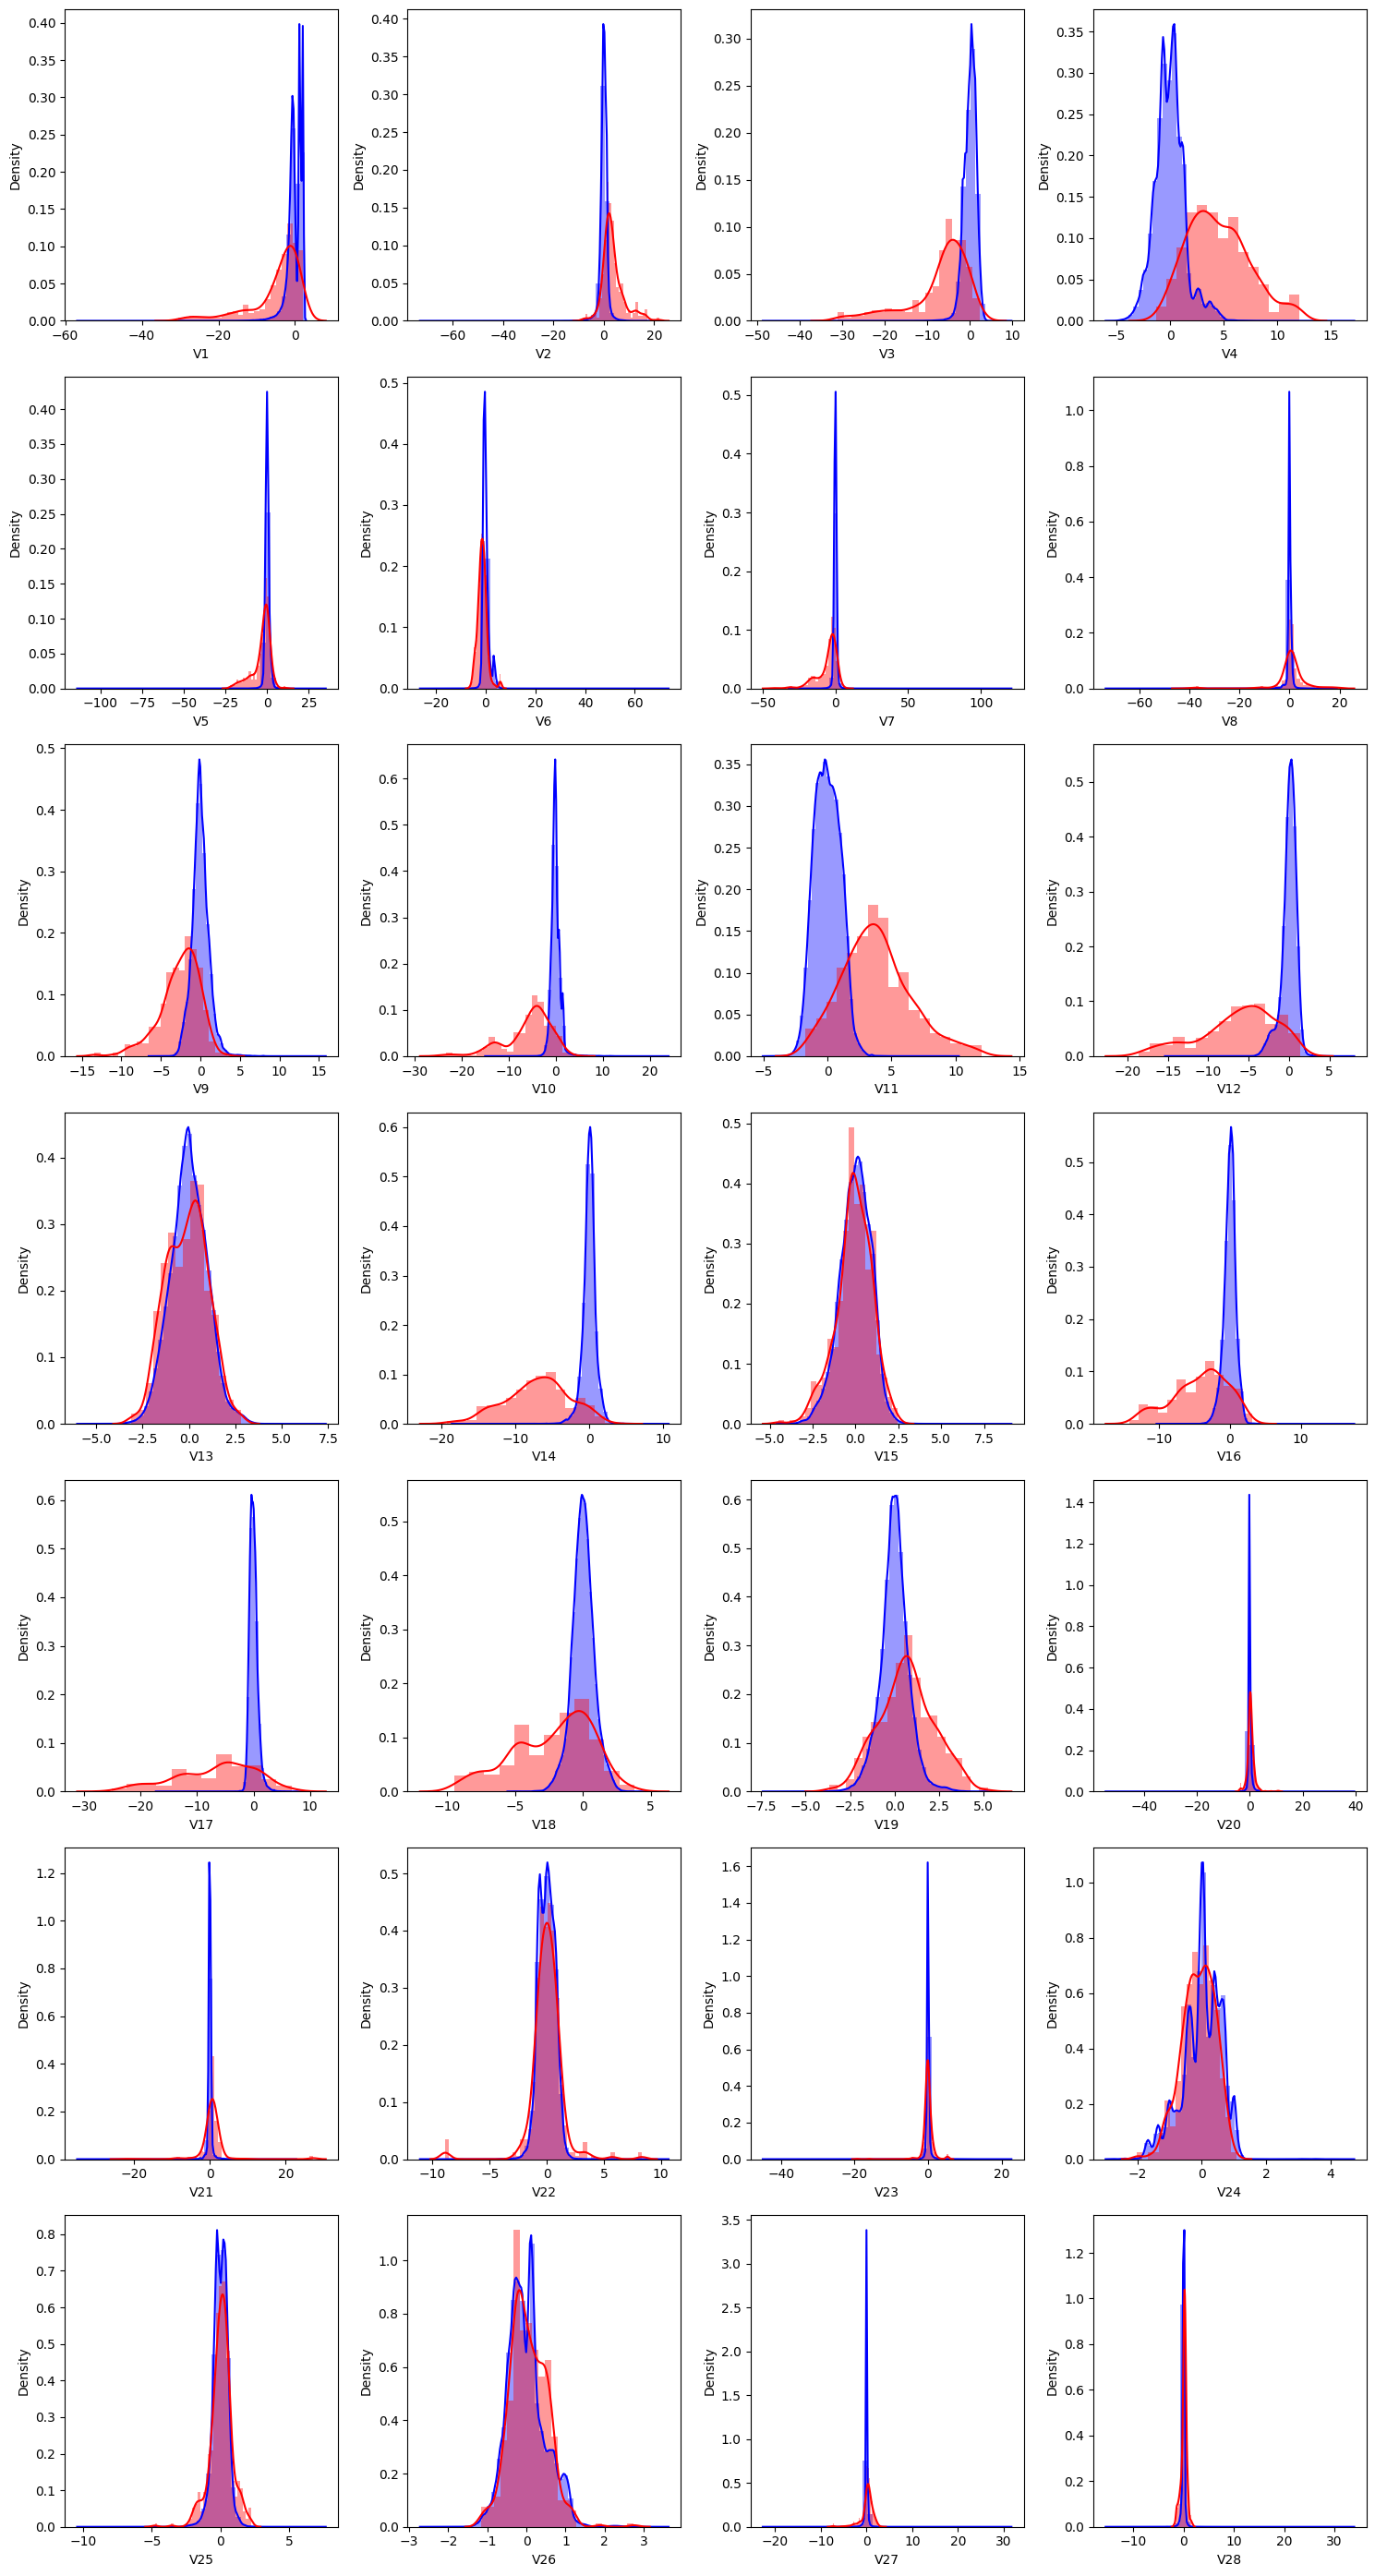

In [7]:
cols = df.columns.drop(['Time', 'Amount', 'Class'])

f, ax = plt.subplots(7, 4, figsize = (15, 28))
#Azul -> No fraude
#Rojo -> Fraude
for i, c in zip(ax.flatten(), cols):
    sns.distplot(df[c][df['Class'] == 0], color = 'blue', ax = i)
    sns.distplot(df[c][df['Class'] == 1], color = 'red', ax = i)
f.tight_layout()

### Relación *Nro. de transacciones/Tiempo*

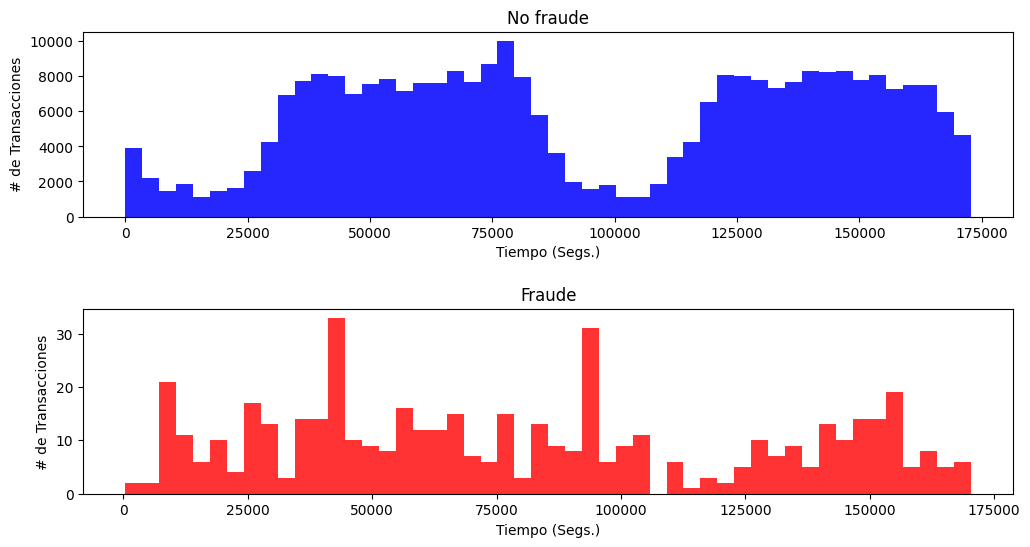

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 6))
plt.subplots_adjust(hspace = 0.5)
ax1.hist(df['Time'][df['Class'] == 0], bins = 50, color = 'blue' ,alpha = 0.85)

ax1.set_xlabel('Tiempo (Segs.)')
ax1.set_title('No fraude')
ax1.set_ylabel('# de Transacciones')


ax2.hist(df["Time"][df['Class'] == 1], bins = 50, color = 'red', alpha = 0.8)

ax2.set_xlabel('Tiempo (Segs.)')
ax2.set_ylabel("# de Transacciones")
ax2.set_title('Fraude')
plt.show()

### Relación *Monto/Nro. de transacciones*

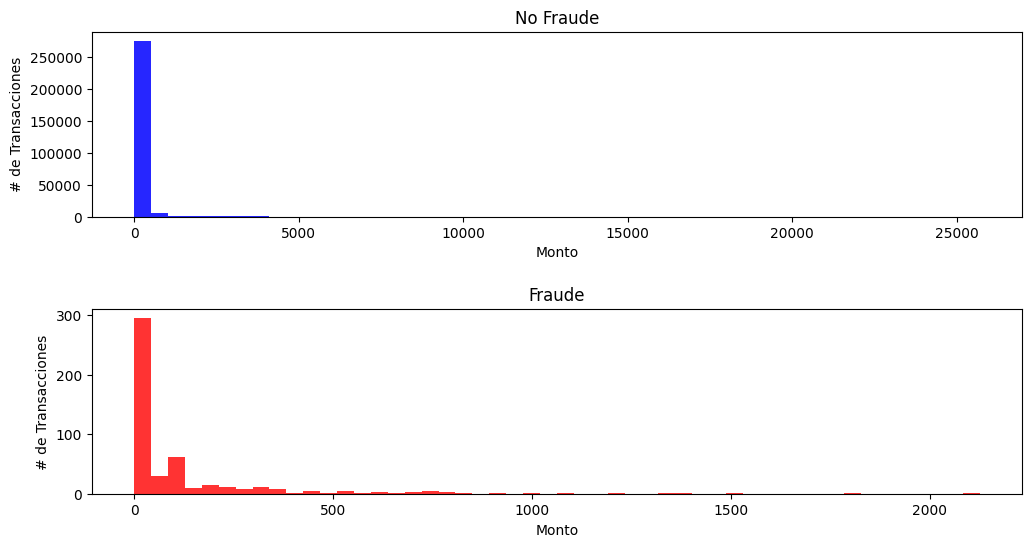

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 6))
plt.subplots_adjust(hspace = 0.5)
ax1.hist(df['Amount'][df['Class'] == 0], bins = 50, color = 'blue' ,alpha = 0.85)
ax1.set_xlabel('Monto')
ax1.set_title('No Fraude')
ax1.set_ylabel('# de Transacciones')


ax2.hist(df["Amount"][df['Class'] == 1], bins = 50, color = 'red', alpha = 0.8)
ax2.set_xlabel('Monto')
ax2.set_ylabel("# de Transacciones")
ax2.set_title('Fraude')
plt.show()

##EXTRACCIÓN DE CARACTERÍSTICAS

In [10]:
X = df.drop(['Time', 'Class'], axis = 1)
y = df['Class']
scaler = StandardScaler()
#Estandarización de "Monto"
X['Amount'] = scaler.fit_transform(X[['Amount']])
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


In [12]:
#Division de dataset en "train" y "valid" (20/80)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train)

In [14]:
#Aplicacion de SMOTE (Synthetic Minority Over-sampling Technique) para balancear un conjunto de datos
def oversampling(X_train, y_train):
# Oversampling the imbalanced dataset
    oversample = SMOTE(random_state = 42, sampling_strategy = 0.4)
    X, y = oversample.fit_resample(X_train, y_train)
    counter = Counter(y)
    print(counter)
    return X, y

In [17]:
X_train, y_train = oversampling(X_train, y_train)

Counter({0: 181961, 1: 72784})


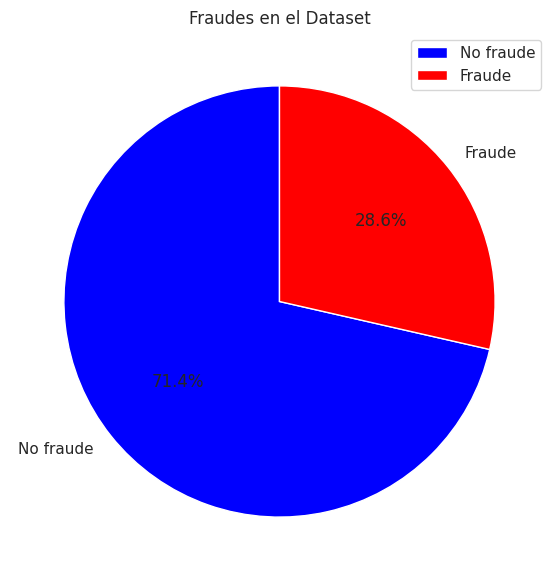

In [20]:
#Resultados del balanceo
sns.set(style="whitegrid")
labels = ['No fraude', 'Fraude']
sizes = y_train.value_counts()

colors = ["blue","red"]

plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,)

plt.title('Fraudes en el Dataset')
plt.legend()
plt.show()